<a href="https://colab.research.google.com/github/030108ming/deep-learning-with-pytorch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Convert mniist image files into a tensor of 4-Dimensions (# of images ,Height, width, color channel)
transform = transforms.ToTensor()

In [3]:
# Train Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 47081944.67it/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1869724.24it/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13323337.58it/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9297476.22it/s]


Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [4]:
# Test Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Create a small batch size for image ... let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# Define our CNN  model
# Describe convolutional layer and what it's doing( 2 convolutional layers)
# this is just an wxample in the next we'll build model
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)


In [9]:
# grab 1 MNIST record/iamge
for i, (x_train, y_train) in enumerate(train_data):
  break

In [10]:
x_train.shape

torch.Size([1, 28, 28])

In [11]:
x = x_train.view(1, 1, 28, 28)

In [12]:
# perform our first convolution
x = F.relu(conv1(x)) # rectified linear unit our our activation function

In [13]:
# 1 single image, 6 is the filters we asked for , 26x 26
x.shape

torch.Size([1, 6, 26, 26])

In [14]:
# pass thru the pooling layer
x = F.max_pool2d(x, 2, 2) # kernal of 2 and stride of 2

In [15]:
x.shape # 26/2 = 13

torch.Size([1, 6, 13, 13])

In [16]:
# do our second convolutional layer
x = F.relu(conv2(x))

In [17]:
x.shape # again , we didn't set padding so we lose 2 pixles around the outside of images

torch.Size([1, 16, 11, 11])

In [18]:
# pooling layer
x = F.max_pool2d(x, 2, 2)

In [19]:
x.shape # 11/ 2 =5.5  but we have to round down, becaus you can't invent data to round up

torch.Size([1, 16, 5, 5])

In [20]:
((28-2) / 2- 2) / 2

5.5

In [21]:
 # Model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2) # 2x2 kernal and stride 2
    # second pass
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2) # 2x2 kernal and stride 2

    # Review to flatten it out
    x = x.view(-1, 16*5*5) # negative one so that we vary the batch size

    # Fully Connected Layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)




In [22]:
# Createan instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
# loss Function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # smaller learning rate longer its gonna take to train


In [24]:
from threading import current_thread
import time
start_time = time.time()

# Create Variables to Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []


# for loop of Epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0

  # Train
  for b, (x_train,y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(x_train) # get predicted values from the train set. not flattened
    loss = criterion(y_pred, y_train) # how off are we? compare the predictions to correct answers

    predicted = torch.max(y_pred.data,1)[1] # add up the number of correct prediction. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from the batch. True=1, False=0, sum those up
    trn_corr  += batch_corr # keep tracks as we along in training.


    # Updata our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    #  print out some results
    if b%600 == 0:
      print(f'Epoch: {i} Batch : {b} loss: {loss.item()}')


  train_losses.append(loss)
  train_correct.append(trn_corr)




  # Test
  with torch.no_grad(): # no gredient we  don't updata  weights and biases with test
    for b,(x_test,y_test) in enumerate(test_loader):
      y_val = model(x_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F =0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print(f'Training Took : {total/60} minutes!' )

Epoch: 0 Batch : 600 loss: 0.1623610556125641
Epoch: 0 Batch : 1200 loss: 0.1502392590045929
Epoch: 0 Batch : 1800 loss: 0.4744560718536377
Epoch: 0 Batch : 2400 loss: 0.14238706231117249
Epoch: 0 Batch : 3000 loss: 0.007758188061416149
Epoch: 0 Batch : 3600 loss: 0.3836284875869751
Epoch: 0 Batch : 4200 loss: 0.0038223876617848873
Epoch: 0 Batch : 4800 loss: 0.0021286322735249996
Epoch: 0 Batch : 5400 loss: 0.0569545142352581
Epoch: 0 Batch : 6000 loss: 0.00038789428072050214
Epoch: 1 Batch : 600 loss: 0.005851339548826218
Epoch: 1 Batch : 1200 loss: 0.3855525553226471
Epoch: 1 Batch : 1800 loss: 0.004819948226213455
Epoch: 1 Batch : 2400 loss: 0.003216963727027178
Epoch: 1 Batch : 3000 loss: 0.0332382395863533
Epoch: 1 Batch : 3600 loss: 0.5372857451438904
Epoch: 1 Batch : 4200 loss: 0.04561494290828705
Epoch: 1 Batch : 4800 loss: 0.0007510822033509612
Epoch: 1 Batch : 5400 loss: 0.0001173773780465126
Epoch: 1 Batch : 6000 loss: 0.14201366901397705
Epoch: 2 Batch : 600 loss: 0.023733

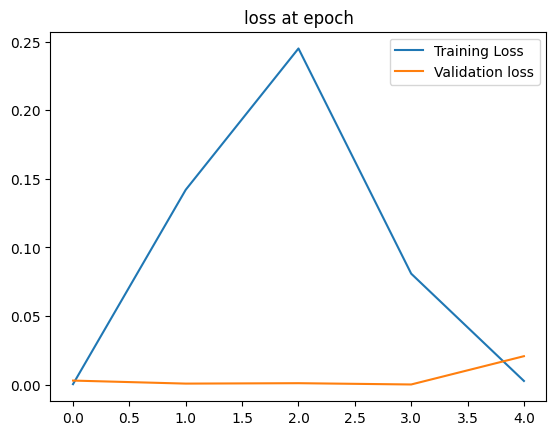

In [25]:
# Graph the loss at epoch
train_losses = [t1.item() for t1 in train_losses]
plt.plot(train_losses, label= "Training Loss")
plt.plot(test_losses, label= "Validation loss")
plt.title("loss at epoch")
plt.legend()


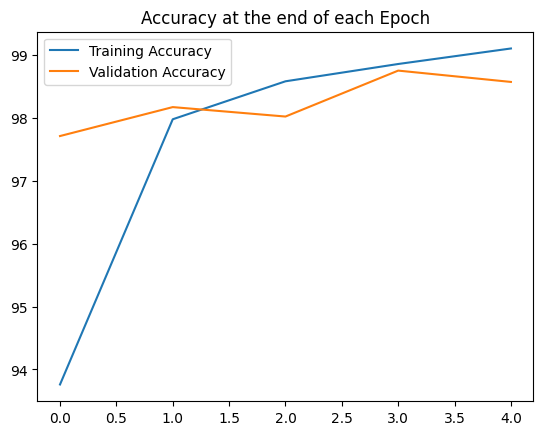

In [26]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label= "Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [27]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [28]:
with torch.no_grad():
  correct = 0
  for x_test,y_test in test_load_everything:
    y_val = model(x_test)
    predicted = torch.max(y_val,1)[1]
    correct +=(predicted == y_test).sum()

In [29]:
# Did for correct
correct.item()/len(test_data)*100

98.57000000000001

In [34]:
# Grab an image
test_data[4143] # Tensor with an image in it ... at end , it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [35]:
# grab just the data
test_data[4143][0]


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [36]:
# Reshape it
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

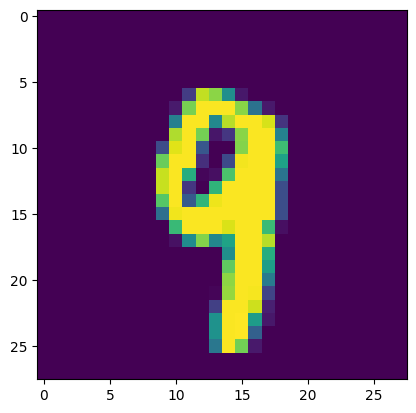

In [39]:
# show the image
plt.imshow(test_data[4143][0].reshape(28,28))

In [40]:
# pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28))  #batch size of 1, 1 color channel, 28x28 image


In [41]:
# check the new prediction ... get probabilitiles
new_prediction

tensor([[-2.1693e+01, -1.8584e+01, -2.1709e+01, -1.5842e+01, -8.6330e+00,
         -1.8415e+01, -3.1769e+01, -1.2734e+01, -1.3396e+01, -1.8273e-04]])

In [42]:
new_prediction.argmax()

tensor(9)